# Exercise 4

## Write a discrete event simulation program for a blocking system, i.e. a system with m service units and no waiting room. The offered traffic A is the product of the mean arrival rate and the mean service time.

### 1. The arrival process is modelled as a Poisson process. Report the fraction of blocked customers, and a confidence interval for this fraction. Choose the service time distribution as exponential. Parameters: m = 10, mean service time = 8 time units, mean time between customers = 1 time unit (corresponding to an offered traffic of 8 Erlang), 10 x 10.000 customers. This system is sufficiently simple such that the analytical solution is known. See the last slide for the solution. Verify your simulation program using this knowledge.

In this assignment, we are supposed to simulate a blocking system with no waiting room, meaning arriving customers either get served or blocked, if no servers are avalaible. We are given:

- $m=10$ servers
- mean service time $=8$
- interarrival time $= 1$
- we should run with 10 batches of 10.000 customers each
- service times are exponential

Using this information, we can begin modelling the problem as a discrete event simulation. I use Poisson-distributed arrivals and exponential arrival times, whereof I can calculate how many customers get blocked when entering the system:

In [13]:
import numpy as np
import heapq
import math
from scipy.stats import expon, erlang, bernoulli, norm, pareto, rv_continuous
import matplotlib.pyplot as plt
from enum import Enum
from heapq import heappush, heappop, heapify
np.random.seed(1234)

class Event(str, Enum):
    ARRIVED = "Arrived"
    SERVICED = "Serviced"
    BLOCKED = "Blocked"
    

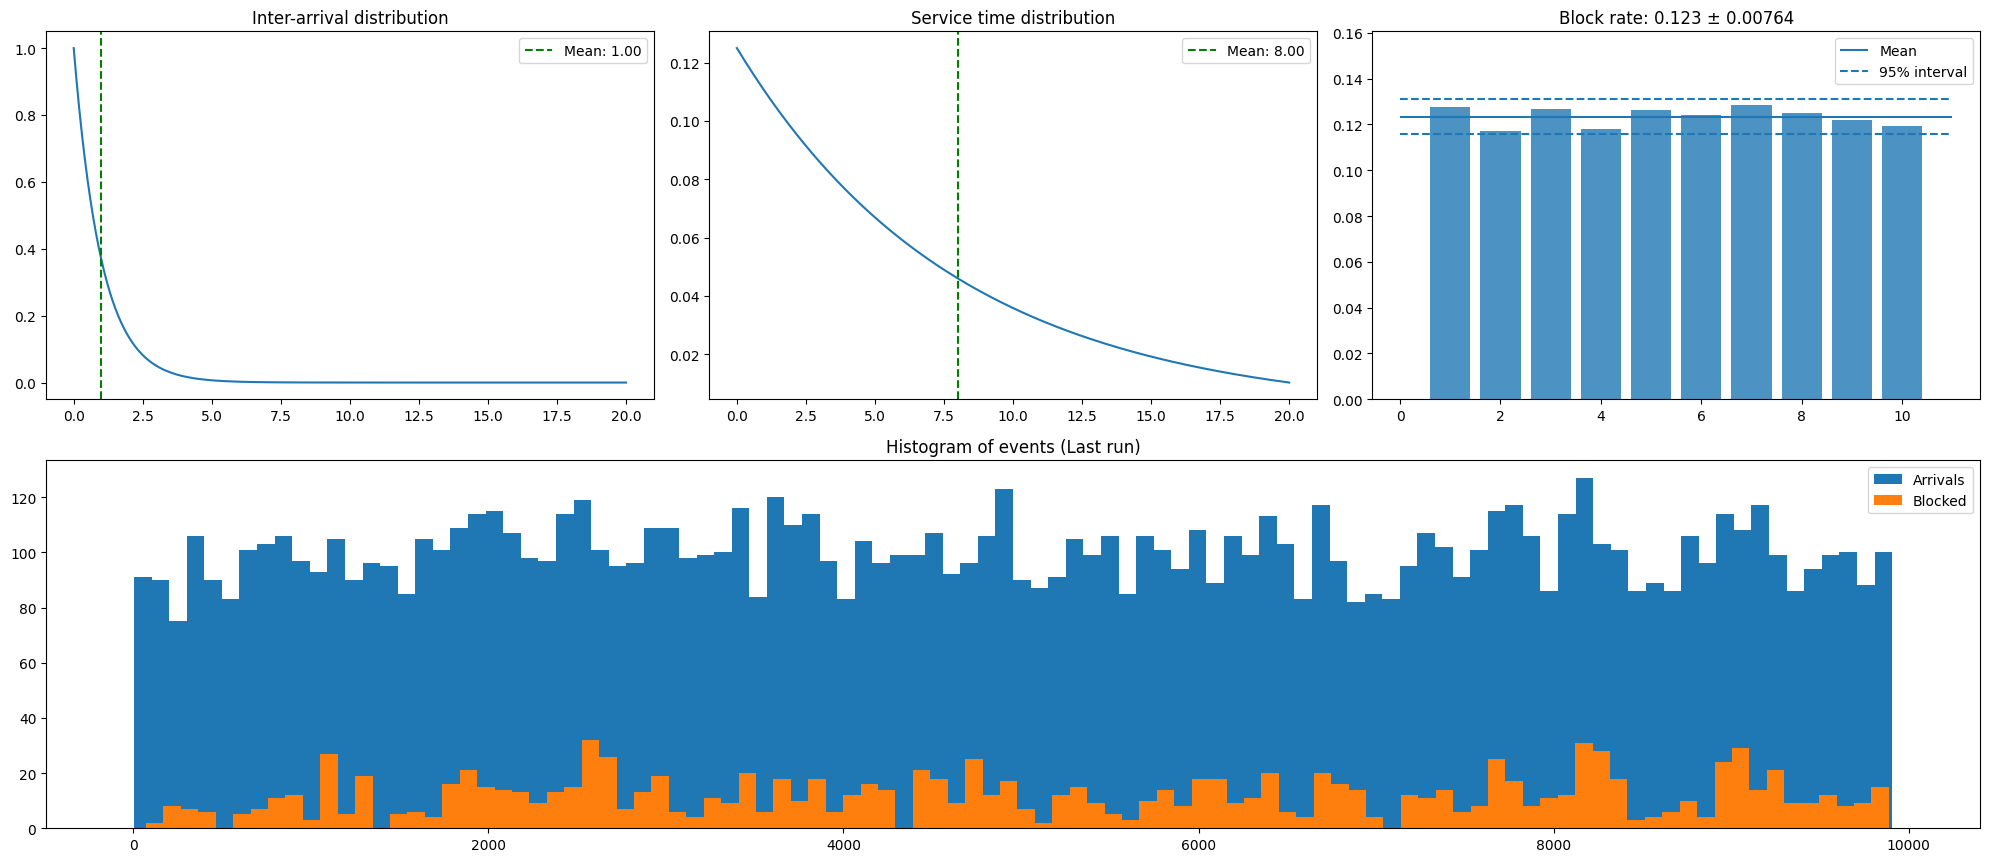


Estimated Blocking Probability: 0.1234
95% Confidence Interval: (0.1158, 0.1310)


In [14]:
def simulate_system(inter_arrival_dist, service_time_dist, m=10, n_customers=10_000):

    service_units = [i for i in range(m)]

    arrival_times = np.cumsum(inter_arrival_dist.rvs(size=n_customers))

    events = [(time.item(), Event.ARRIVED) for time in arrival_times]
    heapify(events)

    n_serviced = 0
    n_blocked = 0
    events_processed = []

    while events:
        event = heappop(events)
        
        match event:
            case (time, Event.ARRIVED):
                if service_units:
                    new_event = (
                        time + service_time_dist.rvs(),
                        Event.SERVICED,
                        service_units.pop(),
                    )                
                else:
                    new_event = (
                        time,
                        Event.BLOCKED,
                    )
                heappush(events, new_event)
            case (_, Event.SERVICED, service_unit):
                service_units.append(service_unit)
                n_serviced += 1
            case (_, Event.BLOCKED):
                n_blocked += 1
        
        events_processed.append(event)

    return n_serviced, n_blocked, events_processed


def simulate_and_print_stats(inter_arrival_dist, service_time_dist, iterations=10, m=10, n_customers=10_000):
    blocked = np.empty(iterations)
    for i in range(iterations):
        _, n_blocked, events = simulate_system(inter_arrival_dist, service_time_dist, m, n_customers)
        blocked[i] = n_blocked

    blocked /= n_customers

    mean = np.mean(blocked)
    std = np.std(blocked)
    ci_low = mean - 1.96 * std
    ci_high = mean + 1.96 * std

    fig = plt.figure(figsize=(20, 9))
    gs = fig.add_gridspec(2, 3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    ax4 = fig.add_subplot(gs[0, 2])

    xs = np.linspace(0, 20, 200)

    ax1.set_title("Inter-arrival distribution")
    ax1.plot(xs, inter_arrival_dist.pdf(xs))
    m_arrival = inter_arrival_dist.mean()
    ax1.axvline(m_arrival, color="g", linestyle="--", label=f"Mean: {m_arrival:.2f}")
    ax1.legend()

    ax2.set_title("Service time distribution")
    ax2.plot(xs, service_time_dist.pdf(xs))
    m_service = service_time_dist.mean()
    ax2.axvline(m_service, color="g", linestyle="--", label=f"Mean: {m_service:.2f}")
    ax2.legend()

    arrivals = [event[0] for event in events if event[1] == Event.ARRIVED]
    blocks = [event[0] for event in events if event[1] == Event.BLOCKED]
    ax3.set_title("Histogram of events (Last run)")
    ax3.hist(arrivals, bins=100, label="Arrivals")
    ax3.hist(blocks, bins=100, label="Blocked")
    ax3.legend()
    
    ax4.set_title(f"Block rate: {mean:.3f} ± {1.96 * std:.5f}")
    ax4.bar(np.arange(iterations) + 1, blocked, alpha=0.8)
    ax4.hlines(mean, xmin=0, xmax=iterations + 1, label="Mean")
    ax4.hlines(ci_high, xmin=0, xmax=iterations + 1, linestyles="--", label="95% interval")
    ax4.hlines(ci_low, xmin=0, xmax=iterations + 1, linestyles="--")
    ax4.set_ylim(0, 1.25 * np.max(blocked))
    ax4.legend()
    fig.tight_layout(rect=[0, 0.03, 1, 1])  
    plt.show()
    
    print("\nEstimated Blocking Probability: {:.4f}".format(mean))
    print("95% Confidence Interval: ({:.4f}, {:.4f})".format(ci_low, ci_high))

inter_arrival_dist = expon(scale=1)
service_time_dist = expon(scale=8)

mean = simulate_and_print_stats(inter_arrival_dist, service_time_dist)


We observe the distribution of inter-arrivals, having a mean of 1, following an exponential distribution. Furthermore, the distribution of the service time also follows an exponential distribution, with a mean of 8. The blocking rate of the $m=10$ servers can be observed to the right plot, wherein the average blocking rate is 12.04%. This means that circa 12% of customers were blocked when arriving, meaning 12% of customers came at a time where all servers $m$ were occupied and thus, these customers were not served. The 95%-confidence also lays nicely around 12%, meaning we are quite certain that between 11% - 13% of customers would in general be blocked when arriving. When we see in the large plot that this blocking percentages fluctuates and different amounts of customers arrive at different time - some coming in bulk which puts more strain on the system.

Now, we can compare it to the analytical Erlang B result, which is calculates the blocking probability $B(m,a)$:
$$
B(m,a) = \frac{\frac{A^m}{m!}}{\sum ^m _{k=0} \frac{A^k}{k!}}
$$
Here, $m$ is the number of servers, and $A$ is the offered traffic in Erlangs, $A=s\cdot\lambda=8$ Erlang:


In [16]:
A = 8
m = 10

def factorial(n):
    if n in (0, 1):
        return 1
    return n * factorial(n - 1)

a = A ** m / factorial(m)
b = sum(A ** i / factorial(i) for i in range(m + 1))

print(f"Analytical Erlang B blocking probability: {a / b:.4f}")
print(f"Absolute error vs simulation: {abs((a / b ) - 0.1224) :.6f}")

Analytical Erlang B blocking probability: 0.1217
Absolute error vs simulation: 0.000739


Analytical Erlang B blocking probability: 0.1217

Absolute error vs simulation: 0.000739

Since there is only an absolute error of -0.0007, the simulation can be deemed a sucess, since it produced results are consistent with the theoretical Erland B model.

Futhermore, since the theoretical Erlang B blocking probability is within the 95%-confidence interval for the simulation of (0.1158, 0.1310), thus, the simulation is statistically consistent with the theoretical Erlang B model.

## 2. The arrival process is modelled as a renewal process using the same parameters as in Part 1 when possible. Report the fraction of blocked customers, and a confidence interval for this fraction for at least the following two cases

### (a) Experiment with Erlang distributed inter arrival times The Erlang distribution should have a mean of 1

$\textbf{(a)}$ To explore the effect of more regular arrival patterns, we simulate the same blocking system using Erlang-distributed interarrival times, specifically an Erlang(2, 2) distribution. This maintains the same mean of 1 as the original exponential case but with lower variability. The rest of the system parameters remain unchanged.

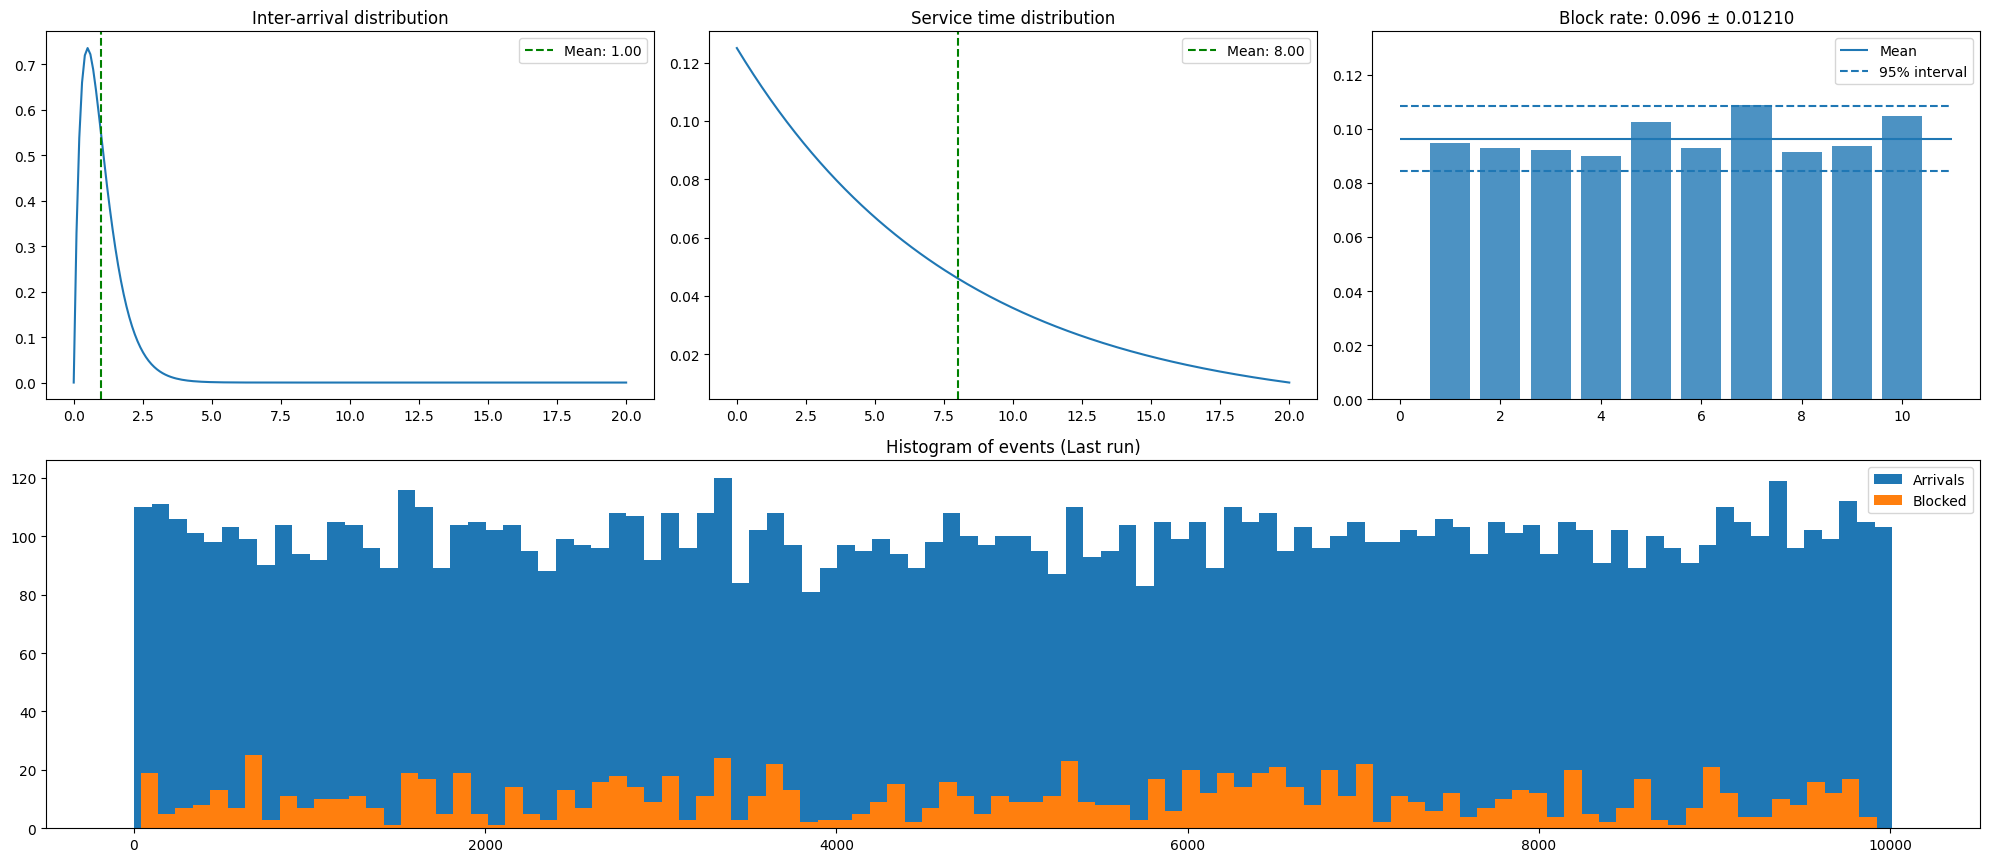


Estimated Blocking Probability: 0.0964
95% Confidence Interval: (0.0843, 0.1085)


In [17]:
inter_arrival_dist = erlang(a=2, scale=1/2)
service_time_dist = expon(scale=8)

simulate_and_print_stats(inter_arrival_dist, service_time_dist)

The simulation shows a blocking probability of approximately 9.6%, with a 95% confidence interval ranging from 8.43% to 10.85%. 

This makes sense, since the Erlang(2,2) distribution has the same mean as the exponential distribution but lower variability. This results in more regular and evenly spaced arrivals, which reduces the chance that many customers arrive in a short span and overwhelm the system. Thus, the blocking probability is lower than with the more variable exponential arrivals, leading to a lower blocking probability.

### (b) hyper exponential inter arrival times. The parameters for the hyper exponential distribution should be p1 = 0.8, λ1 = 0.8333, p2 = 0.2, λ2 = 5.0.

$\textbf{(b)}$ Now, we will utilize hyper exponential arrival times in the simulation. We are given the values: $p_1=0.8$, $p_2 = 0.2$, $\lambda_1=0.8333$, and $\lambda_2=5$:

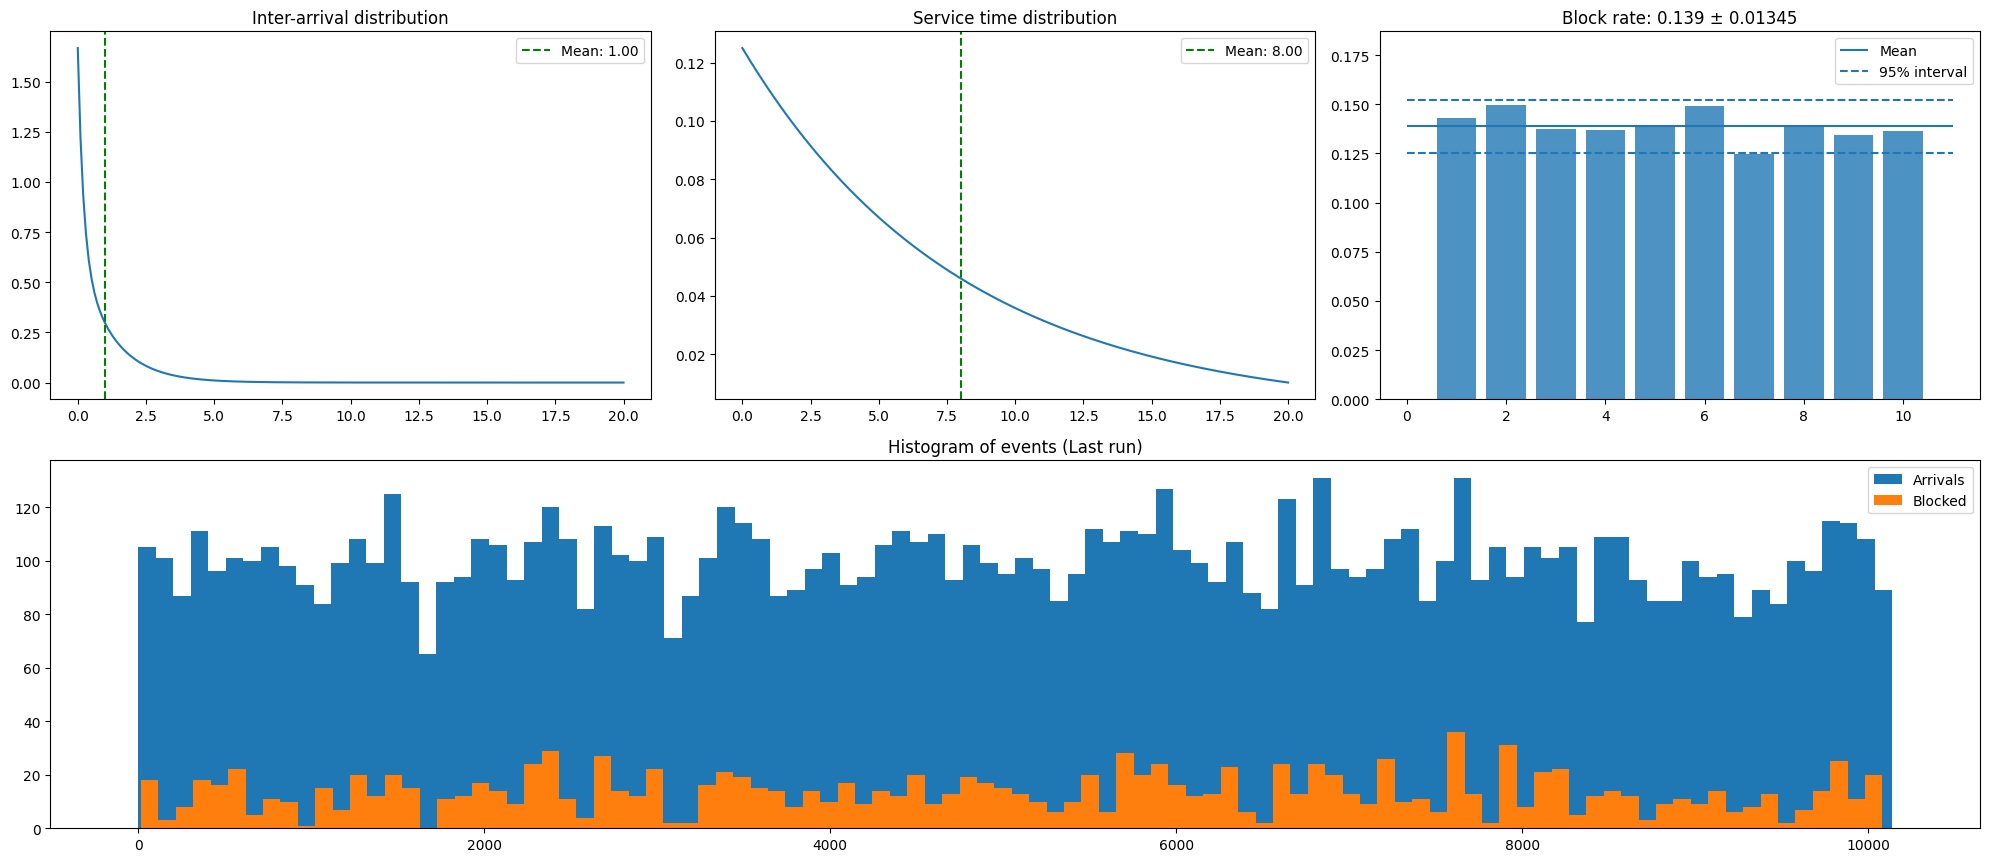


Estimated Blocking Probability: 0.1389
95% Confidence Interval: (0.1254, 0.1523)


In [27]:
class hyperexpon:
    def __init__(self, p1, lambda1, lambda2):
        self.p1 = p1
        self.expon1 = expon(scale=1/lambda1)
        self.expon2 = expon(scale=1/lambda2)

    def mean(self):
        return self.p1 * self.expon1.mean() + (1 - self.p1) * self.expon2.mean()

    def rvs(self, size=1):
        mask = bernoulli.rvs(p=self.p1, size=size) == 1
        expon1 = self.expon1.rvs(size=size)
        expon2 = self.expon2.rvs(size=size)

        return np.where(mask, expon1, expon2)
    
    def pdf(self, xs):
        return self.p1 * self.expon1.pdf(xs) + (1 - self.p1) * self.expon2.pdf(xs)

inter_arrival_dist = hyperexpon(p1=0.8, lambda1=0.8333, lambda2=5.0)
service_time_dist = expon(scale=8)

simulate_and_print_stats(inter_arrival_dist, service_time_dist)

This yields a blocking probability of circa 13.89%, which is somewhat higher than both the exponential and Erland cases, reflecting the increased variability in the arrival process. Specifically, with hyper exponential inter arrival times results in more customers arriving in short time frames, increasing the likelihood of customers not being served (i.e., the blocking probability).

## 3. The arrival process is again a Poisson process like in Part 1. Experiment with different service time distributions with thesame m ean service time and m as in Part 1 and Part 2.

### (a) Constant service time

$\textbf{(a)}$ The arrival process is once again a Poisson process. We set the average service time to a constant, 8:

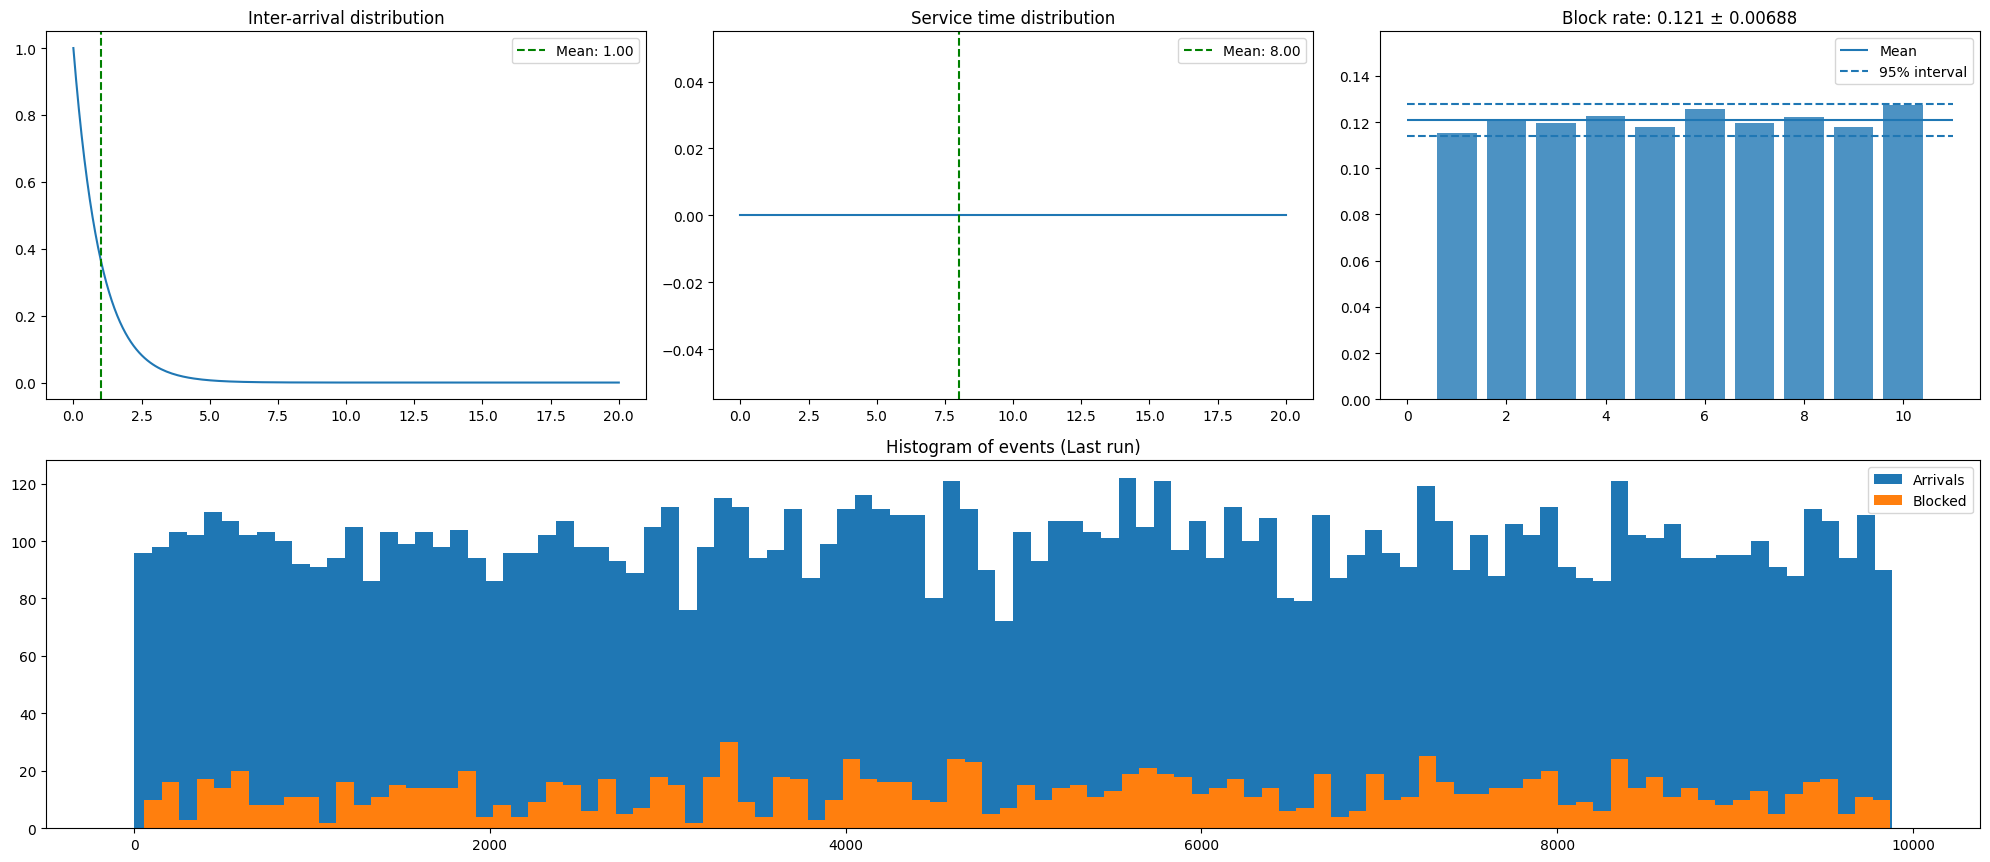


Estimated Blocking Probability: 0.1209
95% Confidence Interval: (0.1140, 0.1277)


In [ ]:
inter_arrival_dist = expon(scale=1)
service_time_dist = type('', (), {
    'rvs': staticmethod(lambda size=None: 8 if size is None else np.full(size, 8)),
    'pdf': staticmethod(lambda x: np.where(x == 8, 1.0, 0.0)),
    'mean': staticmethod(lambda: 8)
})() # Constant service time

simulate_and_print_stats(inter_arrival_dist, service_time_dist)

This is quite similar to the exponential case, it makes sense since the mean service time is the same. While this case reduces service variability, it does not affect the inherent randomness of the arrivals.

### (b) Pareto distributed service times with at least k = 1.05 and k = 2.05.

$\textbf{(b)}$ Now, we set the service time to be both Pareto distributed with atleast $k_1=1.05$ and maximumally $k_2=2.05$. In order to calculate the two $\beta$ values, we utilize:
$$
\beta = \frac{8(k-1)}{k}
$$

For k=1.05:


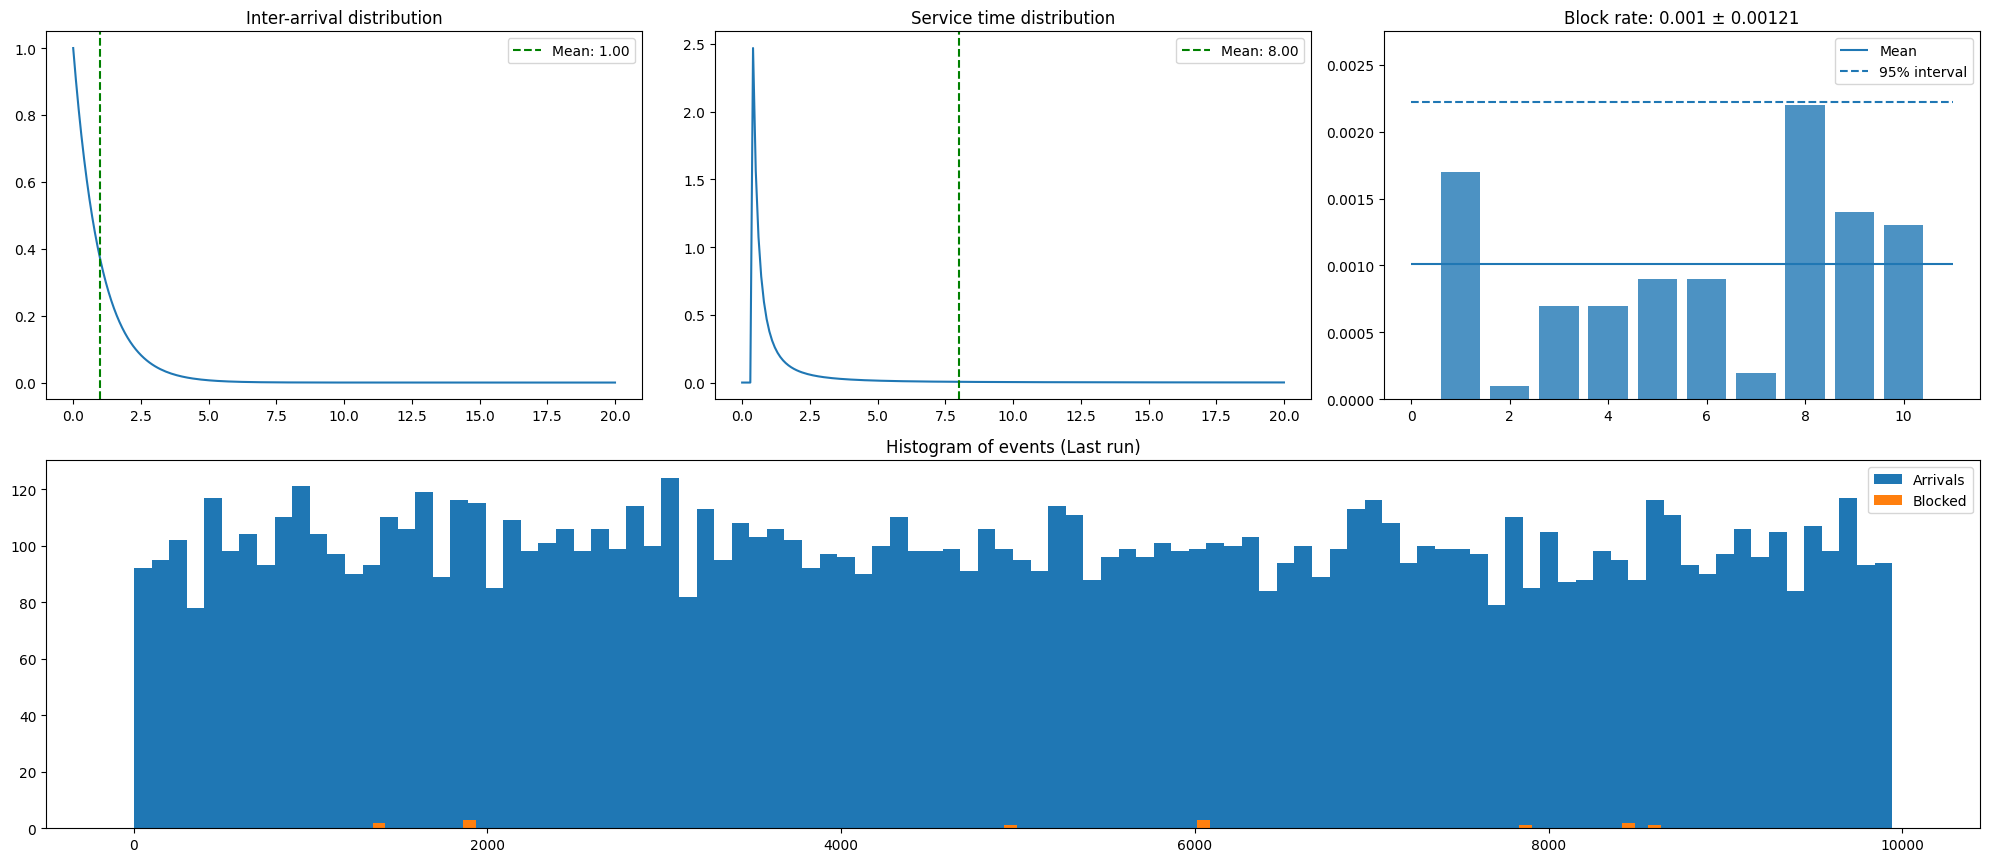


Estimated Blocking Probability: 0.0010
95% Confidence Interval: (-0.0002, 0.0022)

For k=2.05:


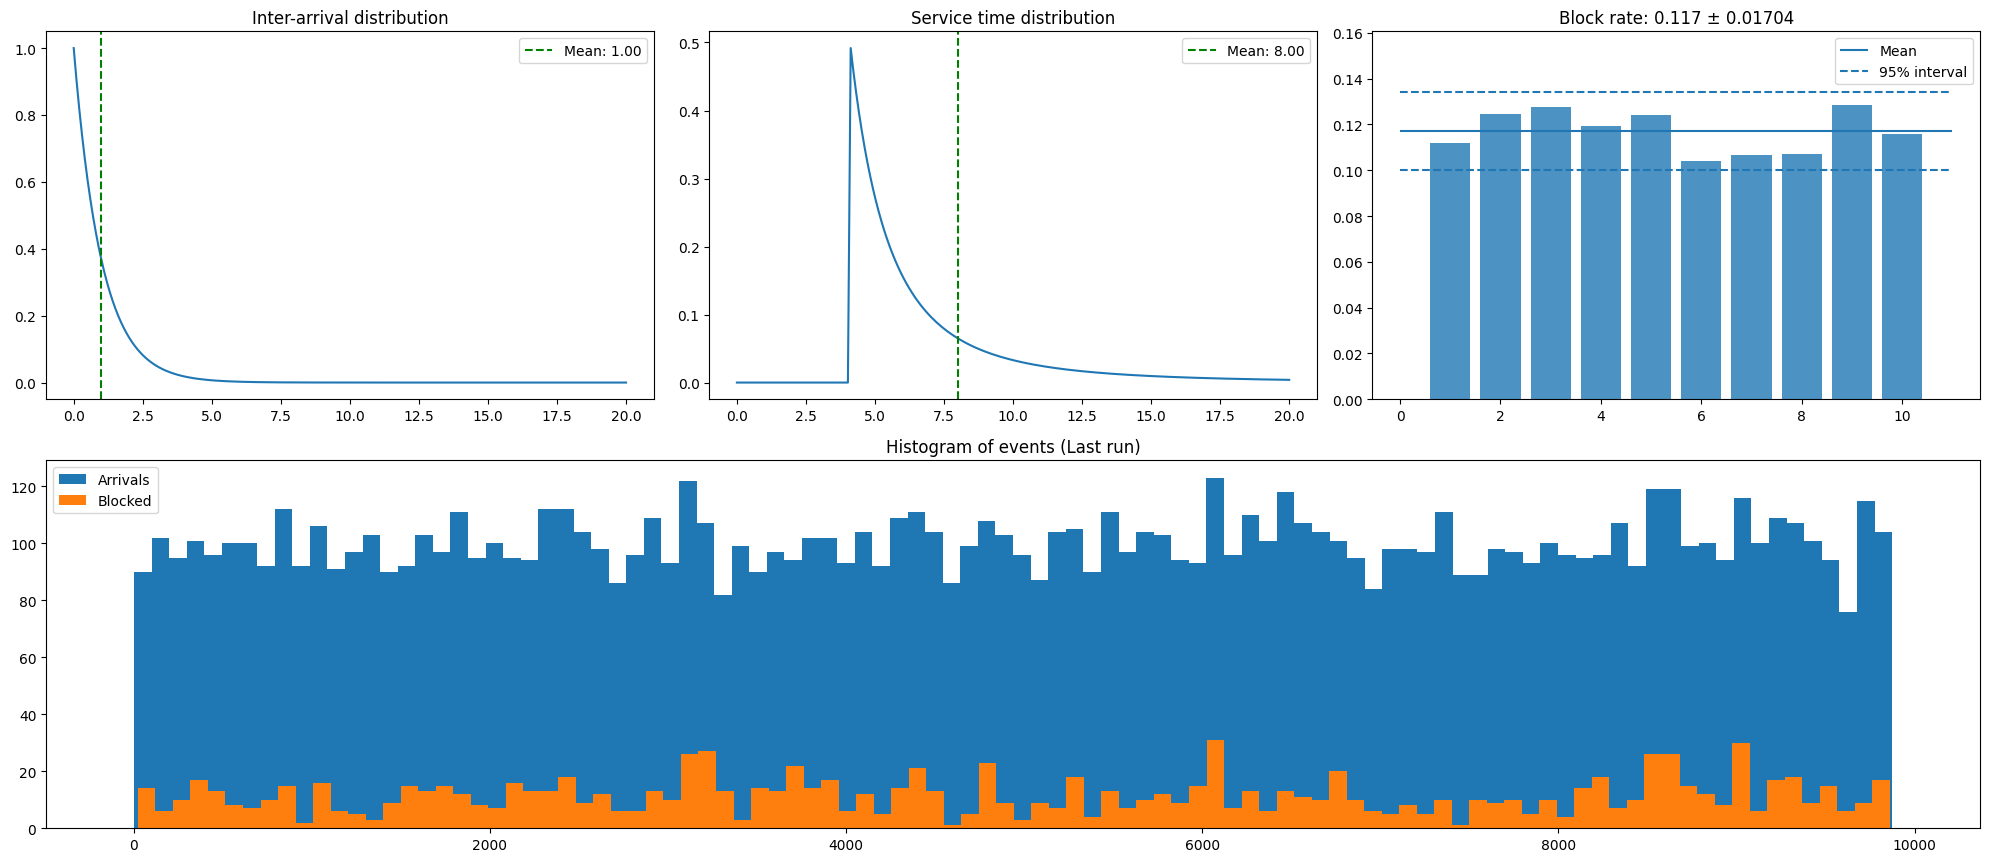


Estimated Blocking Probability: 0.1170
95% Confidence Interval: (0.0999, 0.1340)


In [ ]:
# 4.3.b
k1 = 1.05
beta1 = 8 * (k1 - 1) / k1
service_time_dist = pareto(b=k1, scale=beta1)
inter_arrival_dist = expon(scale=1)
print("For k=1.05:")
simulate_and_print_stats(inter_arrival_dist, service_time_dist)

k2 = 2.05
beta2 = 8 * (k2 - 1) / k2
service_time_dist = pareto(b=k2, scale=beta2)
inter_arrival_dist = expon(scale=1)
print("\nFor k=2.05:")
simulate_and_print_stats(inter_arrival_dist, service_time_dist)

With $k=1.05$, the blocking probability is suprisingly low, despite the extremely heavy-tailed nature of the service time distribution. This is because most service times are actually very short, with only rare but extremely long jobs. These long jobs are infrequent enought that they do not cause significant blocking in the system. On the other hand, with $k=2.05$, service times are more concentrated but still variable, leading to more frequent server occupation and thus, blocking probability in the system.

### (c) Choose one or two other distributions

We set the service distribution to be a hyperexponential distribution, constructed with two exponential components: one with a high rate $\lambda_1 = 1/3$, and a low rate $\lambda_2 = 1/18$, with a probability of selecting the first component of $p=1/3$, and for selecting the second component $1-p=2/3$:

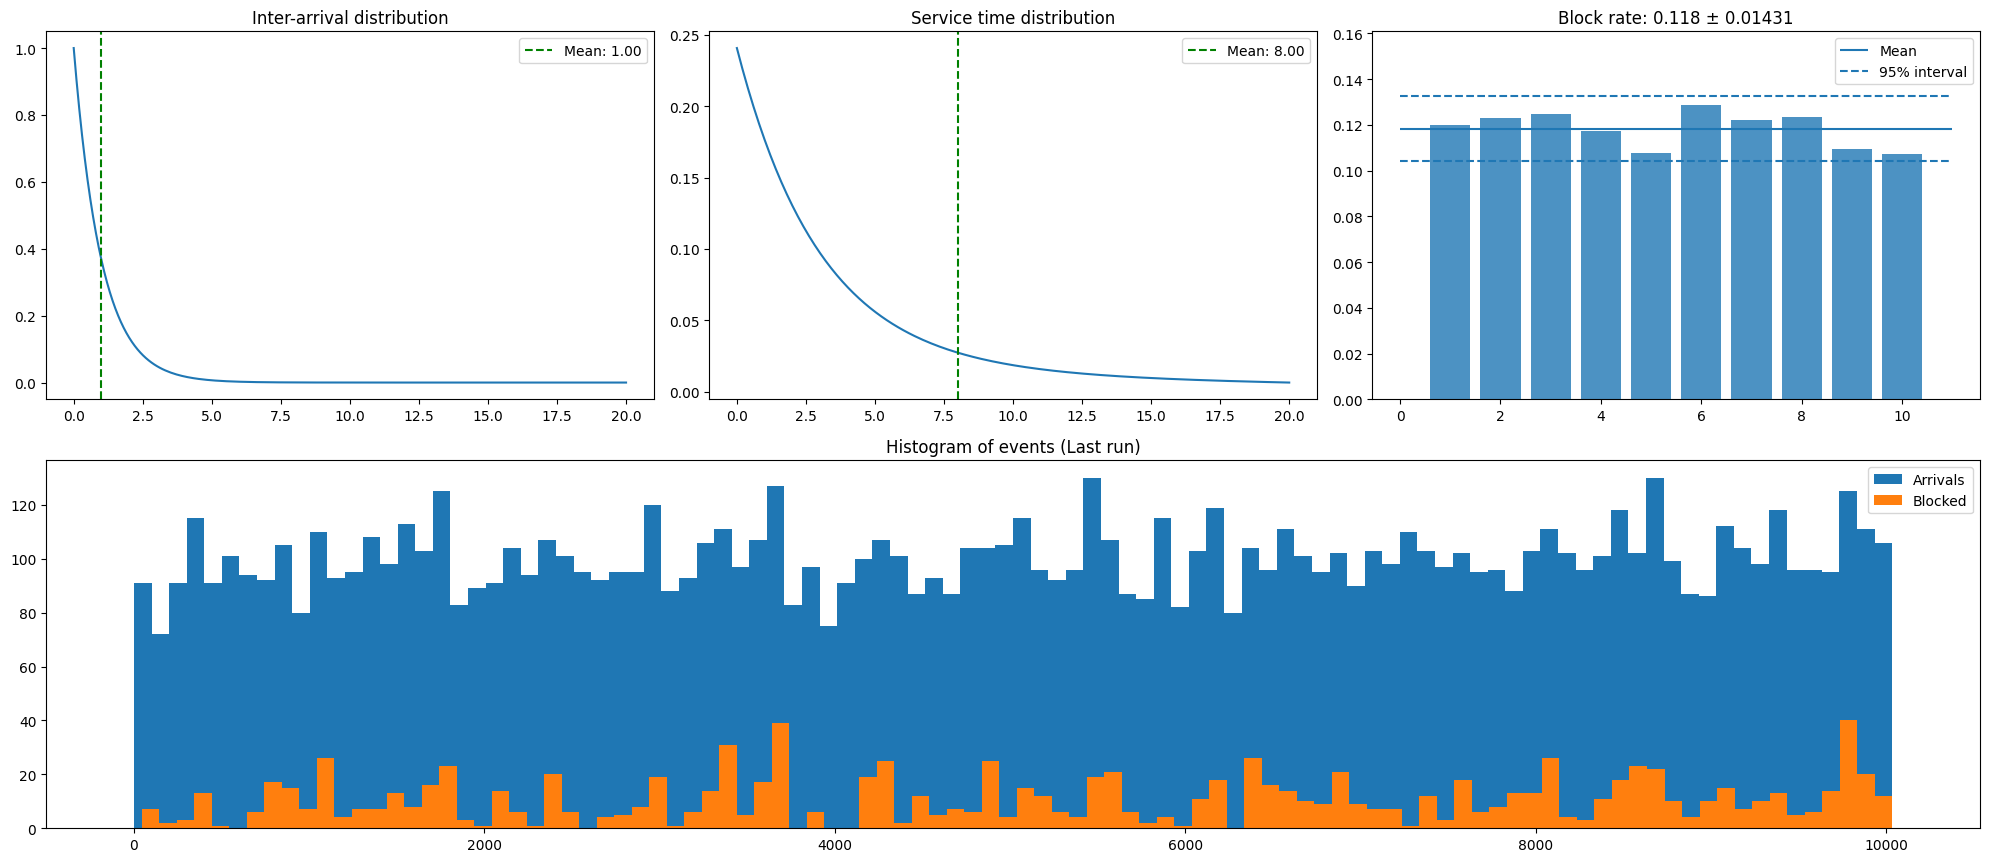


Estimated Blocking Probability: 0.1183
95% Confidence Interval: (0.1040, 0.1327)


In [33]:
inter_arrival_dist = expon(scale=1)
service_time_dist = hyperexpon(1/3, 1/18, 1/3)

simulate_and_print_stats(inter_arrival_dist, service_time_dist)

This yiels a systemn with a slightly lower blocking probability than the exponentially-distributed service times. However, the hyperexponential distributed service times results in greater variability in the system, where some customers are served faster while others are served slower. This result reinforces the idea that service time variability has a significant effect on system performance, even when the mean remains unchanged.